# Deep learning

[Deep learning](https://en.wikipedia.org/wiki/Deep_learning) is a branch of machine learning that relies on [neural networks](https://en.wikipedia.org/wiki/Neural_network) to perform predictive analytics. Neural networks are built with libraries such as [TensorFlow](https://www.tensorflow.org/) and [keras](https://keras.io/). The latter is an open-source Python library that dramatically simplifies the building of neural networks. Under the hood, it uses TensorFlow and other frameworks to do the heavy lifting. With keras, you can build sophisticated neural networks with just a few lines of code and train them to classify images, analyze text for sentiment, do natural-language processing, and perform other tasks at which deep learning excels.

In this exercise, you will use keras to build a series of neural networks that recognize faces. You will train them with images from the famous [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) (LFW) dataset. Along the way, you will learn the basics of building, training, and evaluating neural networks. You will also learn about [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network), or CNNs, which excel at tasks involving computer vision.

![](Images/lfw.png)

## Load the dataset

The first step is to import facial images from the dataset. LFW contains more than 13,000 facial images collected from the Web. Of the more than 5,000 people represented in the dataset, 1,680 have two or more facial images, while only five have 100 or more. We'll set the minimum number of faces per person to 100, which means that five sets of faces corresponding to five famous people will be imported. Each facial image is labeled with the name of the person that the face belongs to.

In [1]:
import numpy as np
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=100)
image_count = faces.images.shape[0]
image_height = faces.images.shape[1]
image_width = faces.images.shape[2]
class_count = len(faces.target_names)

print(faces.target_names)
print(faces.images.shape)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 62, 47)


In total, 1,140 facial images were loaded. Each image measures 47 by 62 pixels for a total of 2,914 pixels per image. That basically means we're working with a model with 2,914 feature columns. Let's check the balance in our dataset by generating a histogram showing how many facial images were imported for each of the five persons, or classes that our neural network will try to predict.

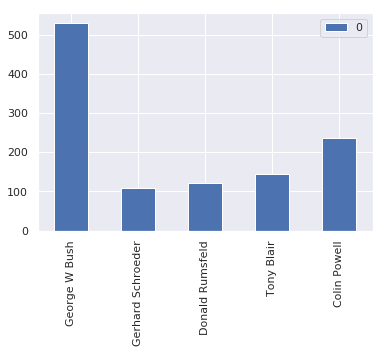

In [2]:
%matplotlib inline

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

counts = Counter(faces.target)
names = {}

for key in counts.keys():
    names[faces.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

The dataset is not very well balanced, but that's not terribly concerning because the net effect will probably be that the model is better at recognizing certain people than others. Let's plot some of the facial images so we can see what they look like

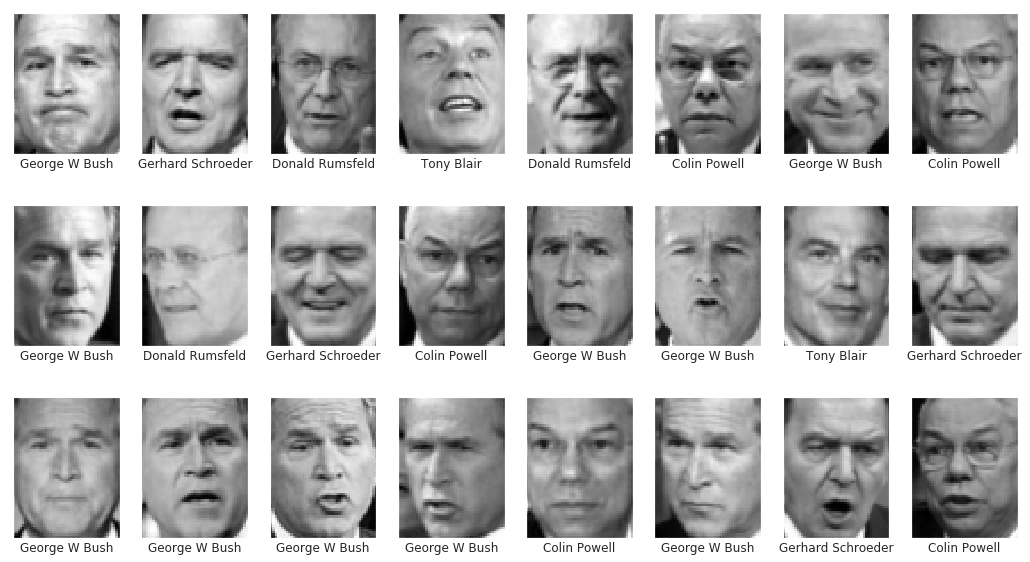

In [3]:
fig, ax = plt.subplots(3, 8, figsize=(18, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gist_gray')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

The next step is to convert the 42x67 images into a flat NumPy array of floats, and to convert the target values (the 0-based indices identifying the person that belongs to a face) into categorical values by [one-hot-encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) them. After that, we'll split the data for training and testing. Rather than allow keras to do the splitting, we'll use scikit-learn's `train_test_split` function because it gives us more control over how the split is performed. And it will allow us to consistently test the network with data it hasn't seen before.

In [4]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

face_images = faces.images.reshape(image_count, image_width * image_height).astype('float32') / 255
face_labels = to_categorical(faces.target)
                             
x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, train_size=0.8, random_state=42)

Using TensorFlow backend.
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Build and train a neural network

We'll start by using keras to build and train a neural network containing one working layer with 128 neurons. We'll use `categorical_crossentropy` as the loss function and a `softmax` output layer, both of which are appropriate for muticlass classification problems. We will also use `adam` as the optimization algorithm. Rather than use a fixed learning rate, `adam` varies the learning rate as training proceeds so the network learns faster in the early stages of training and (hopefully) converges more accurately toward a solution in later stages.

In [5]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(image_width * image_height,)))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               373120    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 373,765
Trainable params: 373,765
Non-trainable params: 0
_________________________________________________________________


Now let's train the neural network. We'll let it run for 100 epochs and then check the result to see if it required more (or less) training.

In [6]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=25)

Train on 912 samples, validate on 228 samples
Epoch 1/100
912/912 [==============================] - 1s 630us/step - loss: 1.5704 - accuracy: 0.4463 - val_loss: 1.3317 - val_accuracy: 0.6272
Epoch 2/100
912/912 [==============================] - 0s 310us/step - loss: 1.3158 - accuracy: 0.4868 - val_loss: 1.2791 - val_accuracy: 0.4868
Epoch 3/100
912/912 [==============================] - 0s 440us/step - loss: 1.1423 - accuracy: 0.5504 - val_loss: 1.1087 - val_accuracy: 0.6053
Epoch 4/100
912/912 [==============================] - 0s 431us/step - loss: 1.0718 - accuracy: 0.5811 - val_loss: 1.0204 - val_accuracy: 0.6316
Epoch 5/100
912/912 [==============================] - 0s 410us/step - loss: 0.9756 - accuracy: 0.6404 - val_loss: 0.9519 - val_accuracy: 0.6754
Epoch 6/100
912/912 [==============================] - 0s 260us/step - loss: 0.9474 - accuracy: 0.6491 - val_loss: 0.9016 - val_accuracy: 0.7588
Epoch 7/100
912/912 [==============================] - 0s 330us/step - loss: 0.8638 

Epoch 57/100
912/912 [==============================] - 0s 381us/step - loss: 0.2970 - accuracy: 0.8991 - val_loss: 0.4261 - val_accuracy: 0.8553
Epoch 58/100
912/912 [==============================] - 0s 458us/step - loss: 0.2060 - accuracy: 0.9342 - val_loss: 0.3968 - val_accuracy: 0.8684
Epoch 59/100
912/912 [==============================] - 0s 523us/step - loss: 0.2294 - accuracy: 0.9254 - val_loss: 0.3865 - val_accuracy: 0.8816
Epoch 60/100
912/912 [==============================] - 1s 702us/step - loss: 0.1972 - accuracy: 0.9276 - val_loss: 0.4764 - val_accuracy: 0.8728
Epoch 61/100
912/912 [==============================] - 1s 709us/step - loss: 0.2488 - accuracy: 0.9079 - val_loss: 0.4340 - val_accuracy: 0.8553
Epoch 62/100
912/912 [==============================] - 1s 642us/step - loss: 0.2203 - accuracy: 0.9211 - val_loss: 0.3556 - val_accuracy: 0.8860
Epoch 63/100
912/912 [==============================] - 1s 787us/step - loss: 0.1869 - accuracy: 0.9441 - val_loss: 0.4188 -

keras's `fit` function returns a `history` object containing information about the training and validation accuracies measured following each epoch of the training. Let's use that information to plot the training and validation accuracy over time.

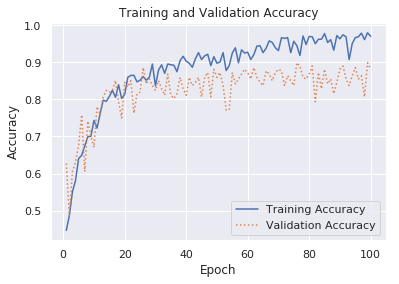

In [7]:
def show_history(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '-', label='Training Accuracy')
    plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.plot()
    
show_history(hist)

In all likelihood, the training accuracy approached 100% (1.0) in later epochs, while the validation accuracy peaked out between 80% and 90%. Let's try widening the working layer to 512 neurons and comparing the results.

In [8]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(image_width * image_height,)))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=25)

Train on 912 samples, validate on 228 samples
Epoch 1/100
912/912 [==============================] - 2s 2ms/step - loss: 2.6869 - accuracy: 0.3147 - val_loss: 1.3441 - val_accuracy: 0.4649
Epoch 2/100
912/912 [==============================] - 1s 2ms/step - loss: 1.2892 - accuracy: 0.5274 - val_loss: 1.2221 - val_accuracy: 0.4956
Epoch 3/100
912/912 [==============================] - 1s 1ms/step - loss: 1.1908 - accuracy: 0.5724 - val_loss: 1.1404 - val_accuracy: 0.6096
Epoch 4/100
912/912 [==============================] - 1s 1ms/step - loss: 1.1108 - accuracy: 0.5779 - val_loss: 1.1174 - val_accuracy: 0.6228
Epoch 5/100
912/912 [==============================] - 1s 1ms/step - loss: 1.0865 - accuracy: 0.6086 - val_loss: 1.0726 - val_accuracy: 0.6053
Epoch 6/100
912/912 [==============================] - 1s 1ms/step - loss: 0.9285 - accuracy: 0.6798 - val_loss: 0.8657 - val_accuracy: 0.7105
Epoch 7/100
912/912 [==============================] - 1s 1ms/step - loss: 0.8611 - accuracy: 0.

Once more, we will plot the accuracy over time to assess how well the network learned from the training data.

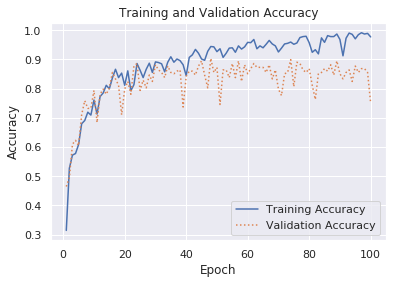

In [9]:
show_history(hist)

Were the results significantly different than before? Probably not. But now let's modify the network so that it contains four hidden layers of 128 neurons each. It's the same number of neurons as the previous model, but the network itself is narrower and deeper. You should find that this model trains somewhat faster.

In [10]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(image_width * image_height,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=25)

Train on 912 samples, validate on 228 samples
Epoch 1/100
912/912 [==============================] - 1s 1ms/step - loss: 1.4706 - accuracy: 0.4408 - val_loss: 1.3985 - val_accuracy: 0.4649
Epoch 2/100
912/912 [==============================] - 0s 450us/step - loss: 1.4029 - accuracy: 0.4583 - val_loss: 1.3895 - val_accuracy: 0.4649
Epoch 3/100
912/912 [==============================] - 0s 381us/step - loss: 1.3479 - accuracy: 0.4890 - val_loss: 1.2512 - val_accuracy: 0.5877
Epoch 4/100
912/912 [==============================] - 0s 332us/step - loss: 1.3065 - accuracy: 0.5143 - val_loss: 1.2408 - val_accuracy: 0.5307
Epoch 5/100
912/912 [==============================] - 0s 321us/step - loss: 1.1978 - accuracy: 0.5559 - val_loss: 1.0710 - val_accuracy: 0.6053
Epoch 6/100
912/912 [==============================] - 0s 265us/step - loss: 1.1037 - accuracy: 0.5691 - val_loss: 1.0260 - val_accuracy: 0.6272
Epoch 7/100
912/912 [==============================] - 0s 293us/step - loss: 1.0686 - 

Epoch 57/100
912/912 [==============================] - 0s 433us/step - loss: 0.1787 - accuracy: 0.9430 - val_loss: 0.3940 - val_accuracy: 0.8772
Epoch 58/100
912/912 [==============================] - 0s 425us/step - loss: 0.1417 - accuracy: 0.9539 - val_loss: 0.5732 - val_accuracy: 0.8333
Epoch 59/100
912/912 [==============================] - 0s 297us/step - loss: 0.1661 - accuracy: 0.9364 - val_loss: 0.5132 - val_accuracy: 0.8421
Epoch 60/100
912/912 [==============================] - 0s 314us/step - loss: 0.2697 - accuracy: 0.9024 - val_loss: 0.8622 - val_accuracy: 0.7412
Epoch 61/100
912/912 [==============================] - 0s 304us/step - loss: 0.2894 - accuracy: 0.9013 - val_loss: 0.5437 - val_accuracy: 0.8246
Epoch 62/100
912/912 [==============================] - 0s 431us/step - loss: 0.1729 - accuracy: 0.9375 - val_loss: 0.3942 - val_accuracy: 0.8684
Epoch 63/100
912/912 [==============================] - 0s 491us/step - loss: 0.1845 - accuracy: 0.9419 - val_loss: 1.2583 -

Now let's see what happened during training.

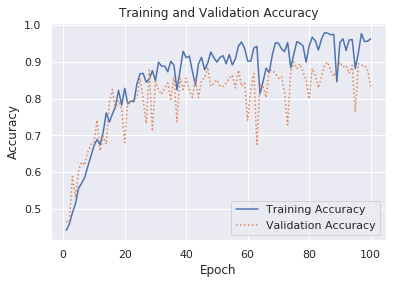

In [11]:
show_history(hist)

Expanding to four hidden layers doesn't seem to help much in terms of accuracy, so let's back off to two layers. You never want more layers (or more neurons) than necessary, and too many can prevent the model from generalizing well.

In [12]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(image_width * image_height,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=25)

Train on 912 samples, validate on 228 samples
Epoch 1/100
912/912 [==============================] - 1s 608us/step - loss: 1.5148 - accuracy: 0.4167 - val_loss: 1.4200 - val_accuracy: 0.4649
Epoch 2/100
912/912 [==============================] - 0s 284us/step - loss: 1.3796 - accuracy: 0.5022 - val_loss: 1.3329 - val_accuracy: 0.5000
Epoch 3/100
912/912 [==============================] - 0s 335us/step - loss: 1.2574 - accuracy: 0.5296 - val_loss: 1.2739 - val_accuracy: 0.5746
Epoch 4/100
912/912 [==============================] - 0s 405us/step - loss: 1.1450 - accuracy: 0.5833 - val_loss: 1.0604 - val_accuracy: 0.6184
Epoch 5/100
912/912 [==============================] - 0s 456us/step - loss: 1.0307 - accuracy: 0.6195 - val_loss: 0.9526 - val_accuracy: 0.6842
Epoch 6/100
912/912 [==============================] - 0s 434us/step - loss: 1.0090 - accuracy: 0.6217 - val_loss: 0.9115 - val_accuracy: 0.6272
Epoch 7/100
912/912 [==============================] - 0s 399us/step - loss: 0.8725 

Epoch 57/100
912/912 [==============================] - 0s 339us/step - loss: 0.2069 - accuracy: 0.9189 - val_loss: 0.5283 - val_accuracy: 0.8246
Epoch 58/100
912/912 [==============================] - 0s 306us/step - loss: 0.1335 - accuracy: 0.9518 - val_loss: 0.5396 - val_accuracy: 0.8465
Epoch 59/100
912/912 [==============================] - 0s 348us/step - loss: 0.2928 - accuracy: 0.8893 - val_loss: 0.8458 - val_accuracy: 0.7675
Epoch 60/100
912/912 [==============================] - 0s 395us/step - loss: 0.1861 - accuracy: 0.9397 - val_loss: 0.5854 - val_accuracy: 0.8246
Epoch 61/100
912/912 [==============================] - 0s 293us/step - loss: 0.1883 - accuracy: 0.9265 - val_loss: 0.4772 - val_accuracy: 0.8640
Epoch 62/100
912/912 [==============================] - 0s 255us/step - loss: 0.1488 - accuracy: 0.9518 - val_loss: 0.5255 - val_accuracy: 0.8596
Epoch 63/100
912/912 [==============================] - 0s 256us/step - loss: 0.2004 - accuracy: 0.9178 - val_loss: 0.4111 -

Time to check the results.

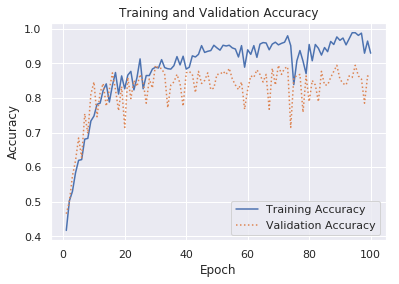

In [13]:
show_history(hist)

At this point, it might be helpful to run some test data through the network and generate a confusion matrix showing how it performed. We can use scikit-learn's `confusion_matrix` function to generate the confusion matrix and seaborn to plot it.

Text(89.18, 0.5, 'Predicted label')

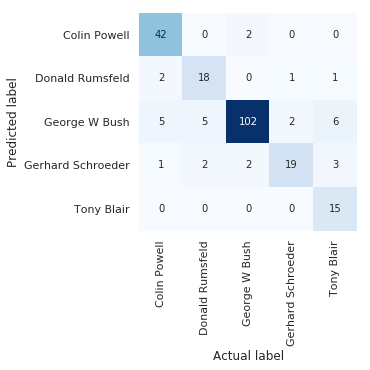

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)

plt.xlabel('Actual label')
plt.ylabel('Predicted label')

How many times did the model correctly identify George W. Bush, who had the most samples in the training set? How many times did it identify him as someone else?

## Use dropout to increase generalization

The fact that training accuracy approaches 100% (1.0) tells us that the network is deep enough and wide enough to learn from the facial data we train it with. But the validation accuracy peaks out much lower. This means that the model isn't *generalizing* well — that is, it isn't responding as well as we would like to facial images it hasn't seen. One way to mitigate that is to introduce *dropout* during training.

Dropout is a commonly used technique to help neural networks generalize better. In keras, you can introduce dropout by following a `Dense` layer with a `Dropout` layer, specifying the fraction of connections that should be randomly dropped between layers in each training epoch. Let's introduce dropout to the network and see if it has an effect on the network's validation accuracy. Because dropout causes the model to train more slowly, we'll increase the number of epochs to 200.

In [15]:
from keras.layers import Dropout

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(image_width * image_height,)))
model.add(Dropout(0.1))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=200, batch_size=25)

Train on 912 samples, validate on 228 samples
Epoch 1/200
912/912 [==============================] - 1s 988us/step - loss: 1.6210 - accuracy: 0.4112 - val_loss: 1.3309 - val_accuracy: 0.5482
Epoch 2/200
912/912 [==============================] - 0s 346us/step - loss: 1.3257 - accuracy: 0.4879 - val_loss: 1.2463 - val_accuracy: 0.4868
Epoch 3/200
912/912 [==============================] - 0s 384us/step - loss: 1.2589 - accuracy: 0.5143 - val_loss: 1.1739 - val_accuracy: 0.5921
Epoch 4/200
912/912 [==============================] - 0s 266us/step - loss: 1.1661 - accuracy: 0.5603 - val_loss: 1.1569 - val_accuracy: 0.4912
Epoch 5/200
912/912 [==============================] - 0s 389us/step - loss: 1.1083 - accuracy: 0.5833 - val_loss: 1.0413 - val_accuracy: 0.5965
Epoch 6/200
912/912 [==============================] - 0s 418us/step - loss: 1.0366 - accuracy: 0.5998 - val_loss: 1.0288 - val_accuracy: 0.6930
Epoch 7/200
912/912 [==============================] - 1s 580us/step - loss: 1.0563 

Epoch 57/200
912/912 [==============================] - 0s 503us/step - loss: 0.3632 - accuracy: 0.8651 - val_loss: 0.3872 - val_accuracy: 0.8728
Epoch 58/200
912/912 [==============================] - 1s 632us/step - loss: 0.3154 - accuracy: 0.8860 - val_loss: 0.4693 - val_accuracy: 0.8246
Epoch 59/200
912/912 [==============================] - 1s 697us/step - loss: 0.3177 - accuracy: 0.9002 - val_loss: 0.4102 - val_accuracy: 0.8640
Epoch 60/200
912/912 [==============================] - 1s 584us/step - loss: 0.3045 - accuracy: 0.8936 - val_loss: 0.3782 - val_accuracy: 0.9035
Epoch 61/200
912/912 [==============================] - 0s 538us/step - loss: 0.3298 - accuracy: 0.8761 - val_loss: 0.4403 - val_accuracy: 0.8509
Epoch 62/200
912/912 [==============================] - 1s 688us/step - loss: 0.3323 - accuracy: 0.8728 - val_loss: 0.4655 - val_accuracy: 0.8421
Epoch 63/200
912/912 [==============================] - 1s 556us/step - loss: 0.3481 - accuracy: 0.8761 - val_loss: 0.4133 -

912/912 [==============================] - 1s 556us/step - loss: 0.1557 - accuracy: 0.9529 - val_loss: 0.3544 - val_accuracy: 0.9035
Epoch 114/200
912/912 [==============================] - 0s 522us/step - loss: 0.2048 - accuracy: 0.9178 - val_loss: 0.3716 - val_accuracy: 0.8904
Epoch 115/200
912/912 [==============================] - 1s 552us/step - loss: 0.1539 - accuracy: 0.9419 - val_loss: 0.4127 - val_accuracy: 0.8728
Epoch 116/200
912/912 [==============================] - 1s 571us/step - loss: 0.1648 - accuracy: 0.9430 - val_loss: 0.3686 - val_accuracy: 0.8860
Epoch 117/200
912/912 [==============================] - 1s 569us/step - loss: 0.1720 - accuracy: 0.9452 - val_loss: 0.3909 - val_accuracy: 0.8772
Epoch 118/200
912/912 [==============================] - 1s 645us/step - loss: 0.2420 - accuracy: 0.9079 - val_loss: 0.3743 - val_accuracy: 0.8684
Epoch 119/200
912/912 [==============================] - 1s 662us/step - loss: 0.2894 - accuracy: 0.8893 - val_loss: 0.3803 - val_ac

Epoch 169/200
912/912 [==============================] - 1s 611us/step - loss: 0.1747 - accuracy: 0.9265 - val_loss: 0.4452 - val_accuracy: 0.8860
Epoch 170/200
912/912 [==============================] - 1s 656us/step - loss: 0.1531 - accuracy: 0.9408 - val_loss: 0.4208 - val_accuracy: 0.8684
Epoch 171/200
912/912 [==============================] - 1s 646us/step - loss: 0.1734 - accuracy: 0.9243 - val_loss: 0.5062 - val_accuracy: 0.8596
Epoch 172/200
912/912 [==============================] - 0s 458us/step - loss: 0.1164 - accuracy: 0.9594 - val_loss: 0.4233 - val_accuracy: 0.8772
Epoch 173/200
912/912 [==============================] - 0s 510us/step - loss: 0.1310 - accuracy: 0.9572 - val_loss: 0.4415 - val_accuracy: 0.8947
Epoch 174/200
912/912 [==============================] - 1s 561us/step - loss: 0.1514 - accuracy: 0.9463 - val_loss: 0.4515 - val_accuracy: 0.8947
Epoch 175/200
912/912 [==============================] - 0s 402us/step - loss: 0.1553 - accuracy: 0.9419 - val_loss: 0

Now let's plot the training history. Does the model seem to generalize better?

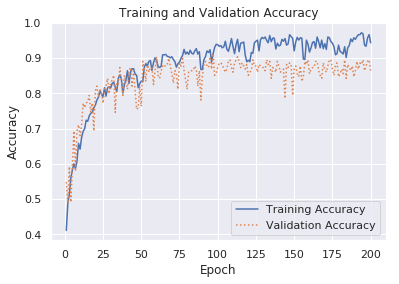

In [16]:
show_history(hist)

While the gap between training accuracy and validation accuracy probably narrowed, validation accuracy probably didn't improve much. That might be an indication that more training data is needed to make the network "smarter." In the confusion matrix above, George W. Bush probably scored the highest for accuracy, and if so, it's no coincidence that the dataset contains almost as many samples of George W. Bush as it does of the other candidates combined.

## Build and train a convolutional neural network (CNN)

State-of-the-art image classification typically isn't done with traditional neural networks, but with deep convolutional neural networks (CNNs) that use convolution kernels to extract features from images and pooling layers to subsample images so features can be detected at various resolutions. Let's use keras to build a CNN and train it with the Labeled Faces in the Wild dataset and see how its performance compares to the other networks. Note that training will take longer, and generally speaking, a CNN performs best when trained with tens (or hundreds) of thousands of images rather than just a few hundred.

![](Images/cnn.png)

In [17]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 1)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 45, 60, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 28, 128)       36992     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 12, 128)        147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 6, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 6, 128)        

Now let's reshape the data to the format that the input layer expects, split it for training and testing, and call `fit` to train the model.

In [18]:
face_images = faces.images.reshape(image_count, image_width, image_height, 1).astype('float32') / 255
x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, train_size=0.8, random_state=42)

hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=25)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train on 912 samples, validate on 228 samples
Epoch 1/50
912/912 [==============================] - 8s 9ms/step - loss: 1.4465 - accuracy: 0.4068 - val_loss: 1.4124 - val_accuracy: 0.4649
Epoch 2/50
912/912 [==============================] - 6s 7ms/step - loss: 1.4255 - accuracy: 0.4649 - val_loss: 1.4018 - val_accuracy: 0.4649
Epoch 3/50
912/912 [==============================] - 7s 8ms/step - loss: 1.4133 - accuracy: 0.4649 - val_loss: 1.3933 - val_accuracy: 0.4649
Epoch 4/50
912/912 [==============================] - 6s 7ms/step - loss: 1.4050 - accuracy: 0.4649 - val_loss: 1.3934 - val_accuracy: 0.4649
Epoch 5/50
912/912 [==============================] - 6s 7ms/step - loss: 1.3702 - accuracy: 0.4660 - val_loss: 1.3189 - val_accuracy: 0.4649
Epoch 6/50
912/912 [==============================] - 6s 7ms/step - loss: 1.2717 - accuracy: 0.4890 - val_loss: 1.3302 - val_accuracy: 0.5395
Epoch 7/50
912/912 [==============================] - 6s 7ms/step - loss: 1.1796 - accuracy: 0.5186 - 

With training complete, let's plot the training and validation accuracy to see how well the network performed.

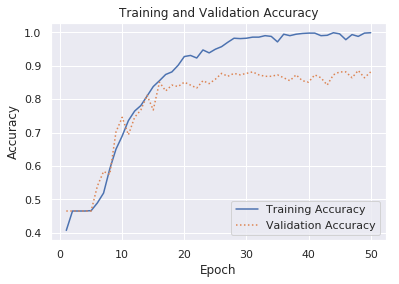

In [19]:
show_history(hist)

As before, we'll run some test data through the network and use a confusion matrix to see how it fared.

Text(89.18, 0.5, 'Predicted label')

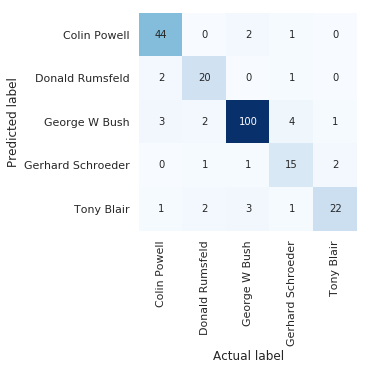

In [20]:
y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)

plt.xlabel('Actual label')
plt.ylabel('Predicted label')

In all likelihood, the CNN exhibited about the same accuracy as a traditional neural network. This isn't surprising given that the dataset we trained it with is relatively small. State-of-the-art CNNs can sometimes execeed a human's ability to classify images. They also require vast amounts of compute power to train and are sometimes 100 or more layers deep.